In [72]:
from autograd import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as u

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0


In [73]:
def make_pupil(radius,npix=128,rtot=20,offset=0.):
    x = np.linspace(-npix/2.,npix/2.,npix)-offset
    x = x*rtot/npix
    xx, yy = np.meshgrid(x,x)
    
    rr = np.sqrt(xx**2 + yy**2)
    mask = rr > radius
    pupil = np.ones_like(rr)
    pupil[mask] = 0
    return pupil


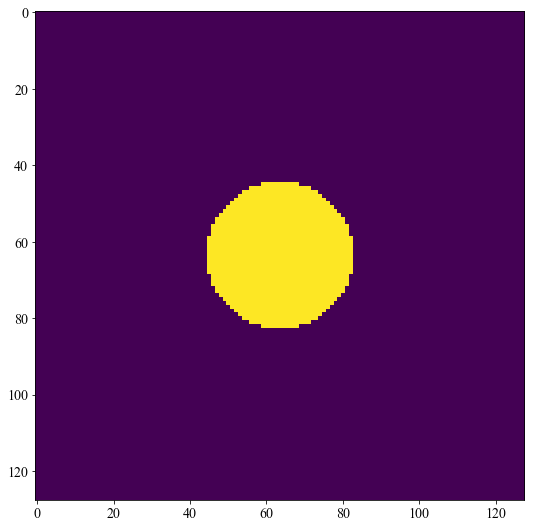

In [74]:
pupil = make_pupil(3.)
plt.imshow(pupil)

### Now let's do a diffraction sim in TensorFlow

In [75]:
import tensorflow as tf
tf.enable_eager_execution()
print("Using TensorFlow version {0}".format(tf.__version__))
T = tf.float64
C = tf.complex64

Using TensorFlow version 1.13.0-rc2


In [117]:
screen_tensor = tf.Variable(np.zeros_like(pupil),dtype=T)
pupil_tensor = tf.constant(pupil,dtype=C)

In [118]:
wavefront_tensor = tf.math.multiply(pupil_tensor,tf.exp(1.j*tf.cast(screen_tensor,C)))

In [119]:
def fftshift2d_tf(a_tensor):
    ### from deepoptics
    input_shape = a_tensor.shape.as_list()

    new_tensor = a_tensor
    for axis in range(2): # changed array shape to 2d explicitly - no batch size
        split = (input_shape[axis] + 1) // 2
        mylist = np.concatenate((np.arange(split, input_shape[axis]), np.arange(split)))
        new_tensor = tf.gather(new_tensor, mylist, axis=axis)
    return new_tensor

def propagate(a_tensor):
    return fftshift2d_tf(tf.fft2d(fftshift2d_tf(a_tensor)))



In [120]:
focal = propagate(wavefront_tensor)

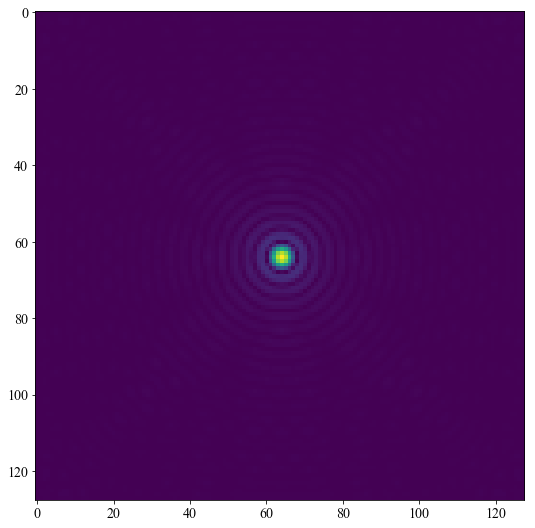

In [121]:
plt.imshow(np.abs(focal.numpy()))

In [122]:
psf = tf.cast(tf.pow(tf.abs(focal),2),C)

In [123]:
uv = propagate(psf)

In [138]:
%%time
with tf.GradientTape(persistent=True) as tape:
    phases_in = tf.Variable(np.zeros(pupil.shape[0]*pupil.shape[1]),dtype=T)
    tape.watch(phases_in)
    
    screen_tensor = tf.reshape(phases_in,(pupil.shape[0],pupil.shape[1]))
    wavefront_tensor = tf.math.multiply(pupil_tensor,tf.exp(1.j*tf.cast(screen_tensor,C)))

    focal = propagate(wavefront_tensor)
    psf = tf.cast(tf.pow(tf.abs(focal),2),C)
    uv = propagate(psf)
    
    loss = tf.reshape(tf.cast(tf.angle(uv),T),[-1])
    
grad = tape.gradient(loss,phases_in)
jac = tape.jacobian(loss, phases_in,experimental_use_pfor=False)


CPU times: user 2min 52s, sys: 19.1 s, total: 3min 11s
Wall time: 2min 41s


In [139]:
phases_in

<tf.Variable 'Variable:0' shape=(16384,) dtype=float64, numpy=array([0., 0., 0., ..., 0., 0., 0.])>

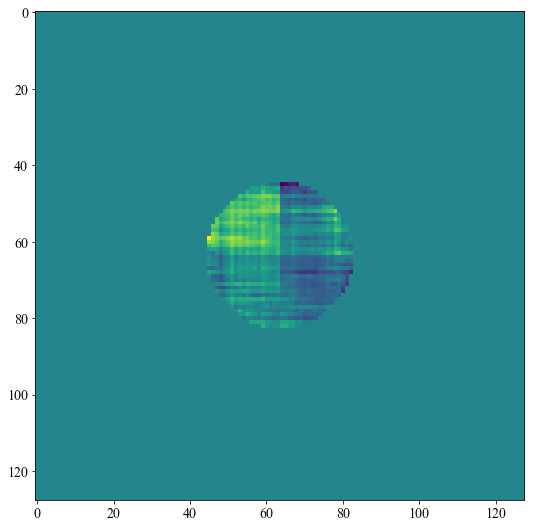

In [140]:
plt.imshow(grad.numpy().reshape([128,128]))

In [145]:
test = jac.numpy().reshape([128,128,128,128])[56,56,:,:]

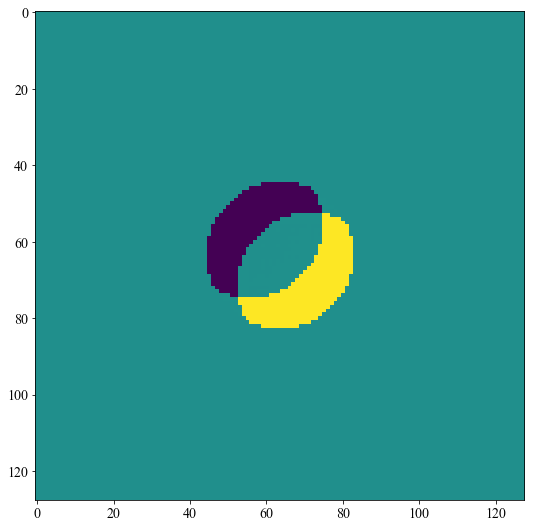

In [146]:
plt.imshow(test)

### This seems to get the same results as autograd, but much slower! It does a while loop for the Jacobian rather than vectorizing. Is there a faster way?